## 캐글 필사
*  목표: 사용자가 다음 주문에서 어떤 제품을 구매할지 예측
*  데이터: 200,000명 이상의 Instacart 사용자로부터 300만 건 이상의 식료품 주문 샘플을 포함

In [1]:
import numpy as np # linear algebra
import pandas as pd # data prcessing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None # default = 'warn'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
files = os.listdir('/content/drive/MyDrive/ESAA/data')
print(files)


Mounted at /content/drive
['sample_submission.csv', 'products.csv', 'aisles.csv', 'departments.csv', 'order_products__prior.csv', 'order_products__train.csv', 'orders.csv']


In [ ]:
# 캐글 필사 버전
# order_products_train_df = pd.read_csv("../input/order_products__train.csv")
# order_products_prior_df = pd.read_csv("../input/order_products__prior.csv")
# orders_df = pd.read_csv("../input/orders.csv")
# products_df = pd.read_csv("../input/products.csv")
# aisles_df = pd.read_csv("../input/aisles.csv")
# departments_df = pd.read_csv("../input/departments.csv")

In [3]:
data_path = '/content/drive/MyDrive/ESAA/data'
order_products_train_df = pd.read_csv(os.path.join(data_path, 'order_products__train.csv'))
order_products_prior_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'))
orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'))
products_df = pd.read_csv(os.path.join(data_path, 'products.csv'))
aisles_df = pd.read_csv(os.path.join(data_path, 'aisles.csv'))
departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'))

In [ ]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


*  각 데이터셋에 행수를 확인

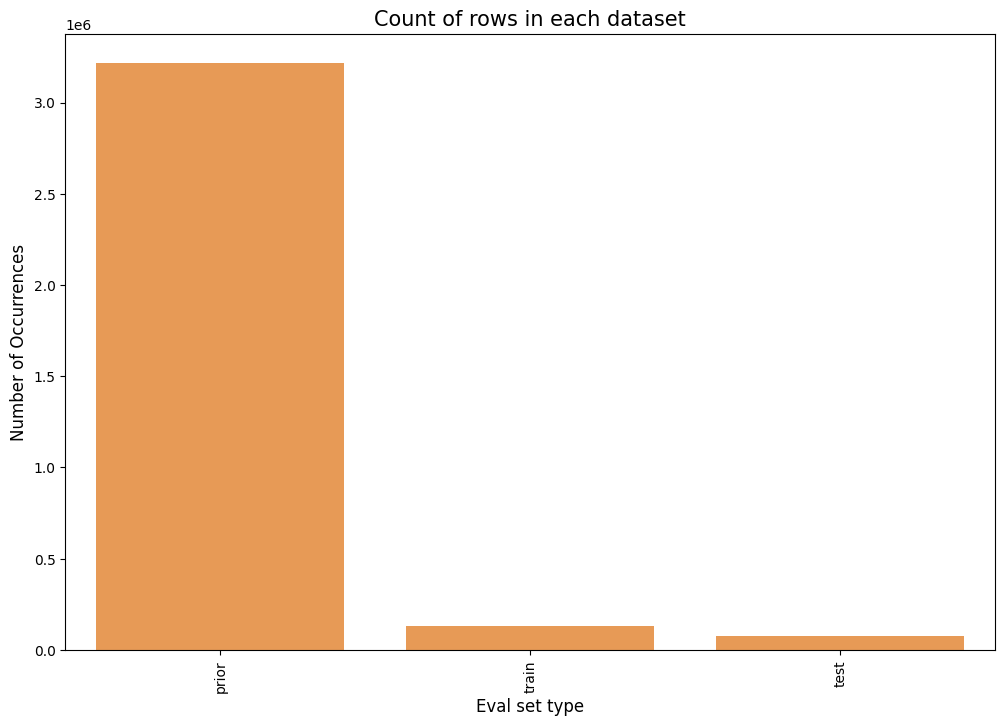

In [ ]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color = color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")['user_id'].aggregate(get_unique_count)
cnt_srs

,user_id
eval_set,
prior,206209
test,75000
train,131209


*  총 206,209명의 고객 중에서 131,209명의 고객의 마지막 구매는 훈련 세트로 제공되며, 나머지 75,000명의 고객에 대해서는 예측을 해야 함.

*  한 고객에게 4개에서 100개의 주문이 주어진다는 주장을 검증할 것임.

<ipython-input-21-0c6ccfb257e6>:1: FutureWarning: The provided callable <function max at 0x7c8c66ad79a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


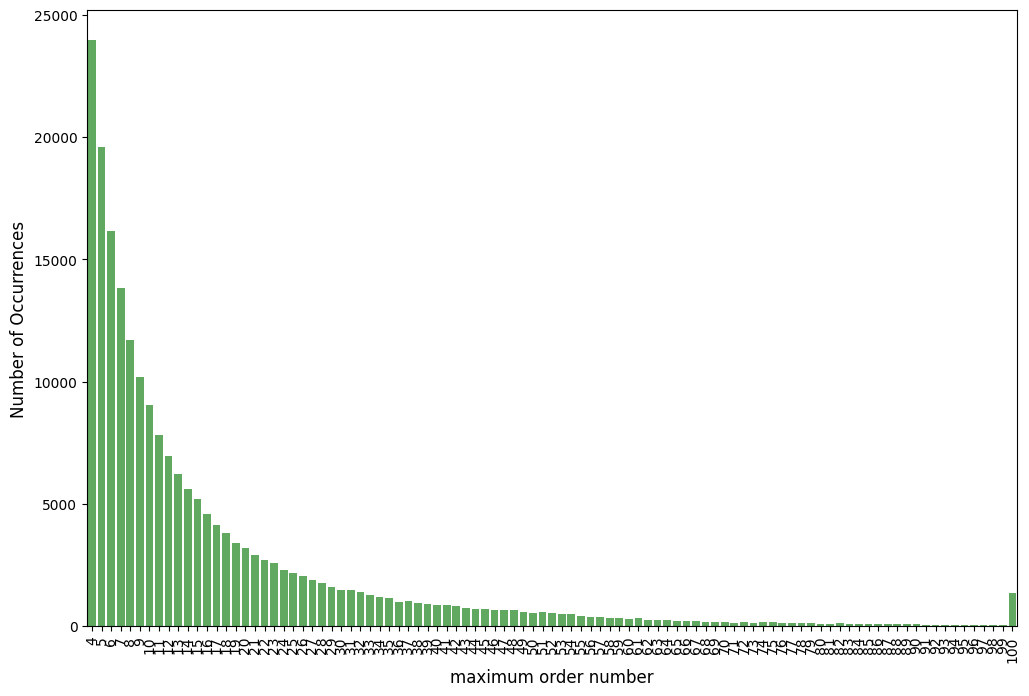

In [ ]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha = 0.8, color = color[2])
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('maximum order number', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

*  요일에 따른 주문 습관 변화 확인


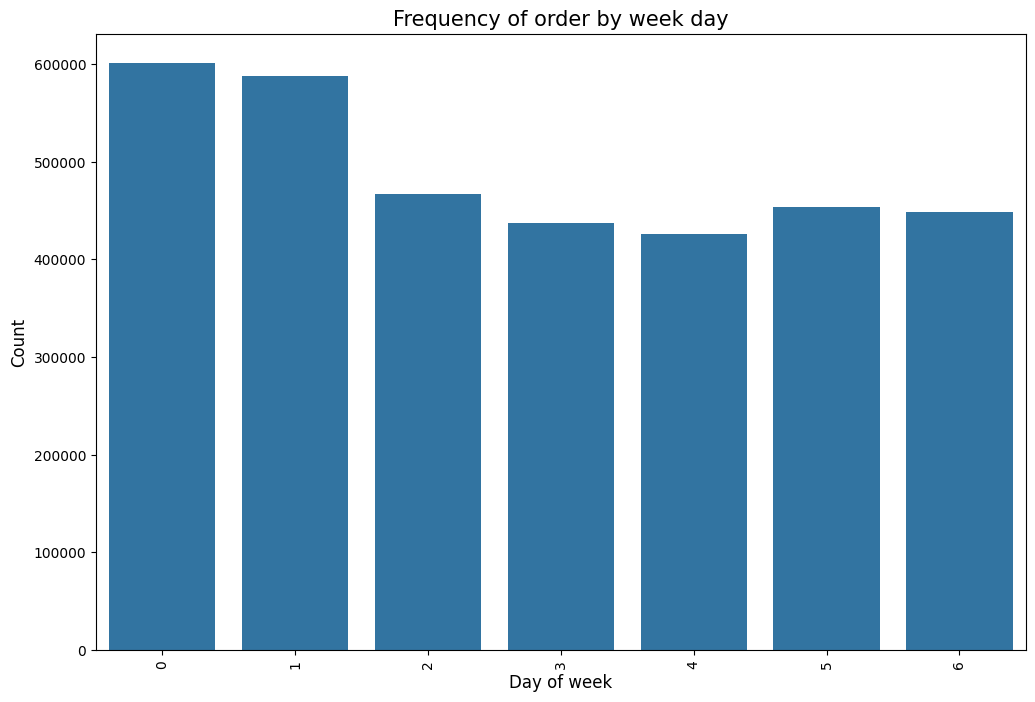

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color = color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

*  요일의 시간에 따른 분포 확인

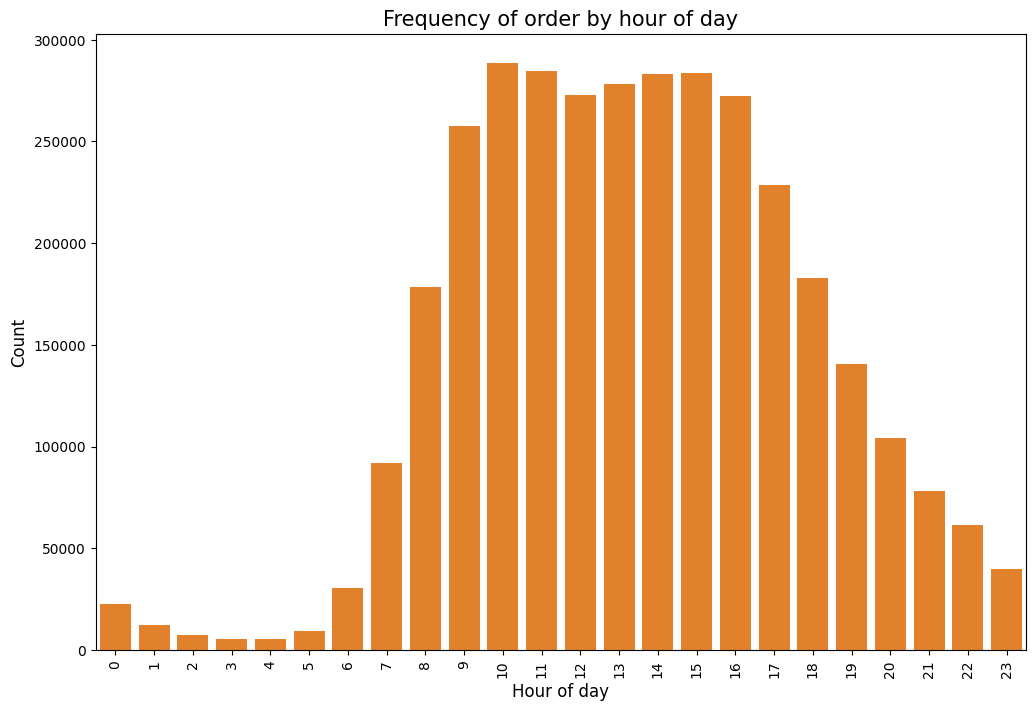

In [ ]:
plt.figure(figsize = (12,8))
sns.countplot(x = "order_hour_of_day", data = orders_df, color = color[1])
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Hour of day', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Frequency of order by hour of day", fontsize = 15)
plt.show()

*  분포를 확인하기 위해서 요일의 요일과 요일의 시간 결합


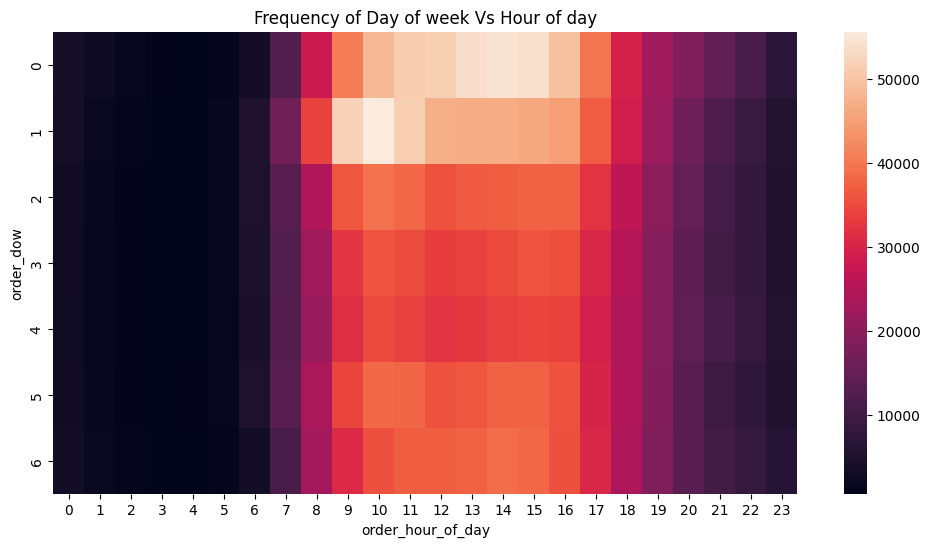

In [ ]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate('count').reset_index()
grouped_df = grouped_df.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

-> 토요일과 일요일이 주문에 있어서 중요한 시간대임.


*  주문마다 시간 간격 확인

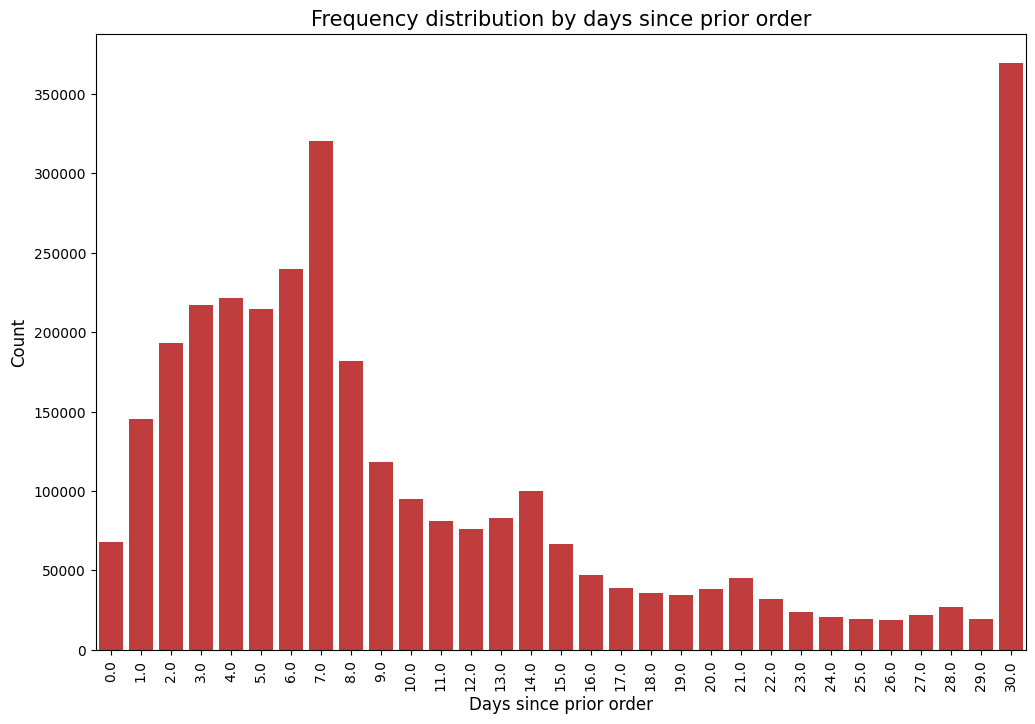

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

-> 일주일에 한번 또는 한 달에 한번 구매하며 14, 21, 28일이 가장 작은 날짜임을 확인 가능

*  prior set과 train set을 통해 재구매 퍼센트 확인

In [ ]:
# percentage of re-orders in prior set
order_products_prior_df.reordered.sum()/ order_products_prior_df.shape[0]

0.5896974667922161

In [ ]:
# percentage of re-orders in train set
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

-> 평균적으로 59% 재구매

*  재주문하지 않는 상품들 확인

In [ ]:
grouped_df = order_products_prior_df.groupby('order_id')['reordered'].aggregate('sum').reset_index()
# 캐글 필사: grouped_df['reordered'].ix[grouped_df['reordered']>1] = 1
grouped_df['reordered'].loc[grouped_df['reordered']>1] = 1
grouped_df.reordered.value_counts()/ grouped_df.shape[0]

,count
reordered,
1,0.879151
0,0.120849


In [ ]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
# grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

,count
reordered,
1,0.93444
0,0.06556


-> 주문의 12% 정도는 재구매 하지 않음. 반면, train set은 6.5%임.

*  각 주문에서 구매한 상품의 수를 확인

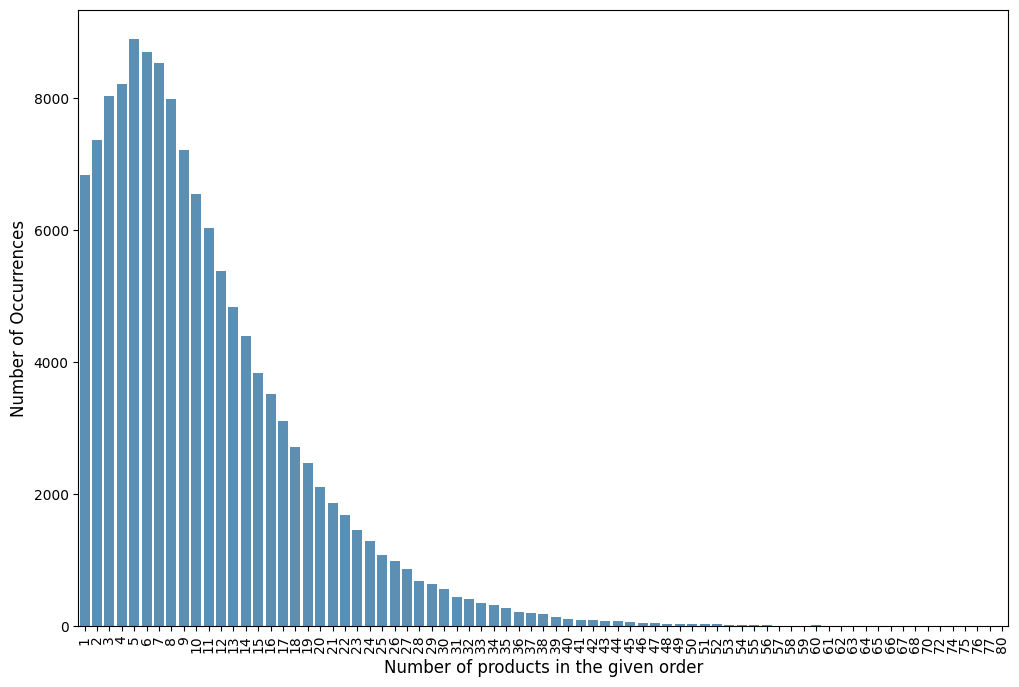

In [ ]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize = (12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8)
plt.ylabel("Number of Occurrences", fontsize = 12)
plt.xlabel("Number of products in the given order", fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

-> 5가 가장 최댓값인 right tailed distrubution임.
*  다른 3가지 파일도 확인

In [ ]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


*   the order_prior의 정보를 가지고 3가지 상품 정보 파일들을 병합

In [ ]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

In [ ]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


-> 대부분은 organic 상품이며 과일임.
*  aisles을 살펴봄


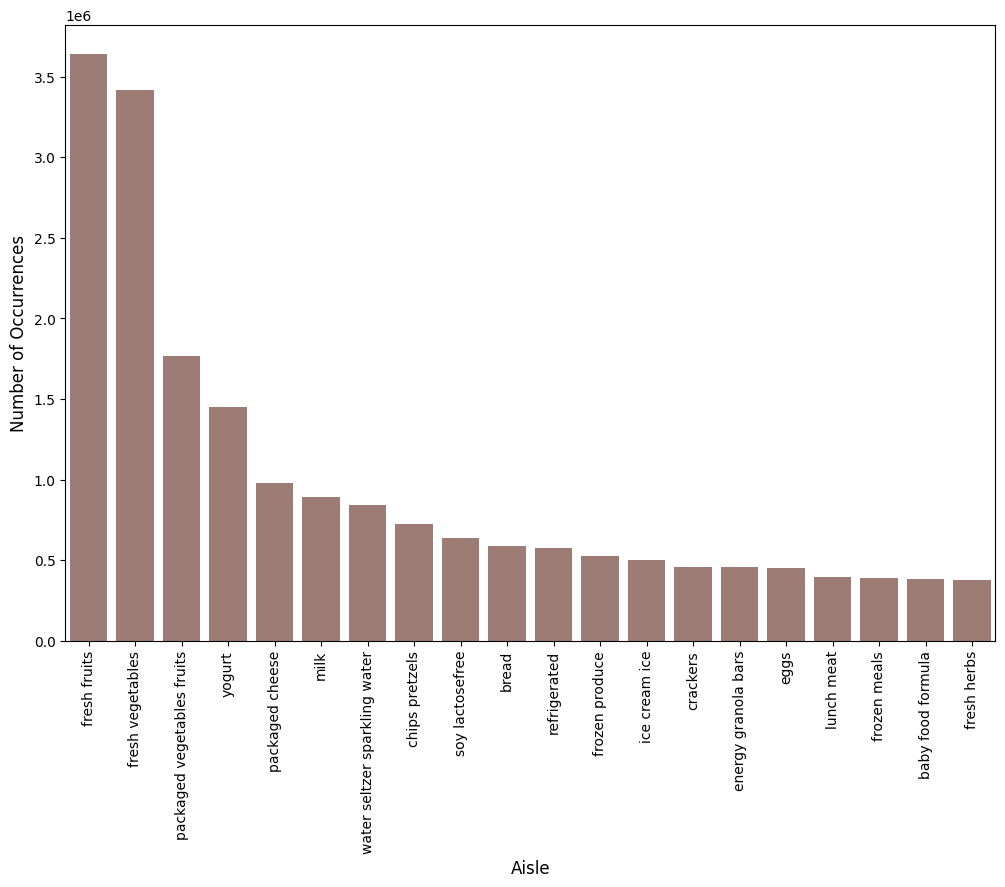

In [ ]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha = 0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Aisle', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

-> 가장 높은 두가지는 fresh fruits와 fresh vegetables임.
*  department size 분포를 살펴봄.


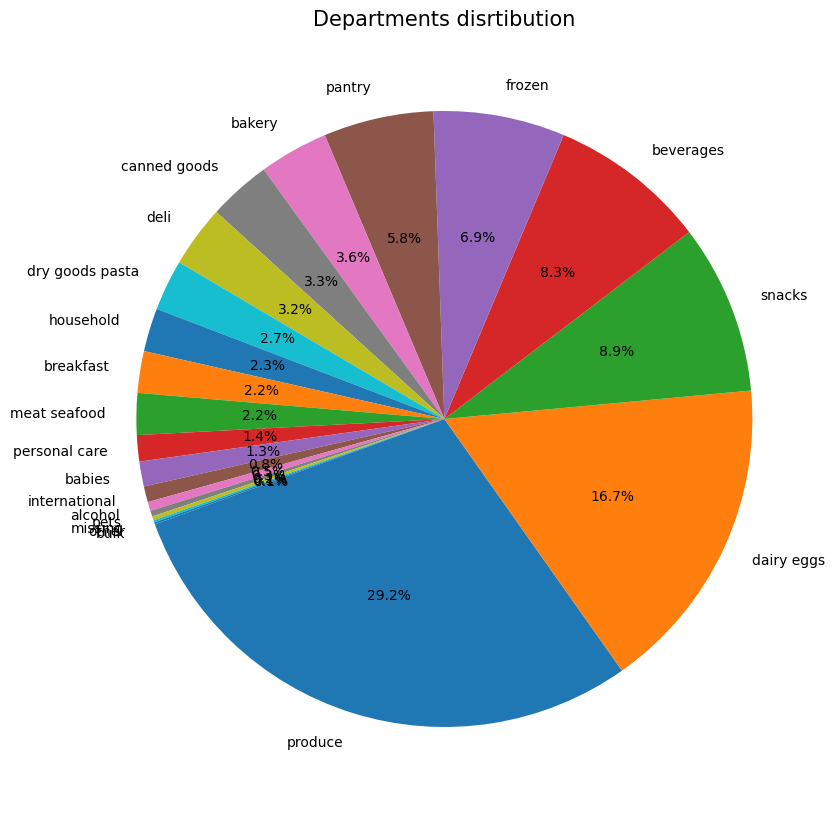

In [ ]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels = labels, autopct='%1.1f%%', startangle=200)
plt.title('Departments disrtibution', fontsize = 15)
plt.show()

-> Produce는 가장 큰 부분임.
*  department wise 재주문 비율

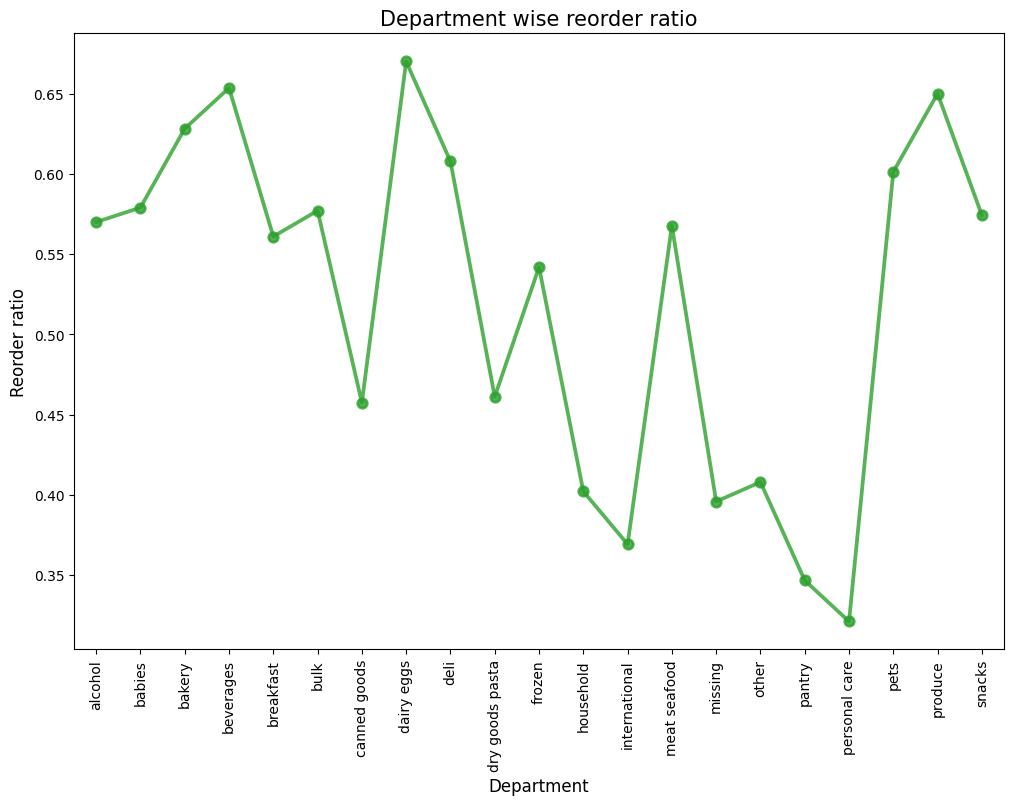

In [ ]:
grouped_df = order_products_prior_df.groupby(['department'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x = grouped_df['department'].values, y = grouped_df['reordered'].values, alpha = 0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize = 12)
plt.xlabel('Department', fontsize = 12)
plt.title("Department wise reorder ratio", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

-> Personal care은 가장 적은 재주문 비율이며 dairy eggs는 가장 높은 재주문 비율을 차지함.
*  Aisle - Reorder 비율:

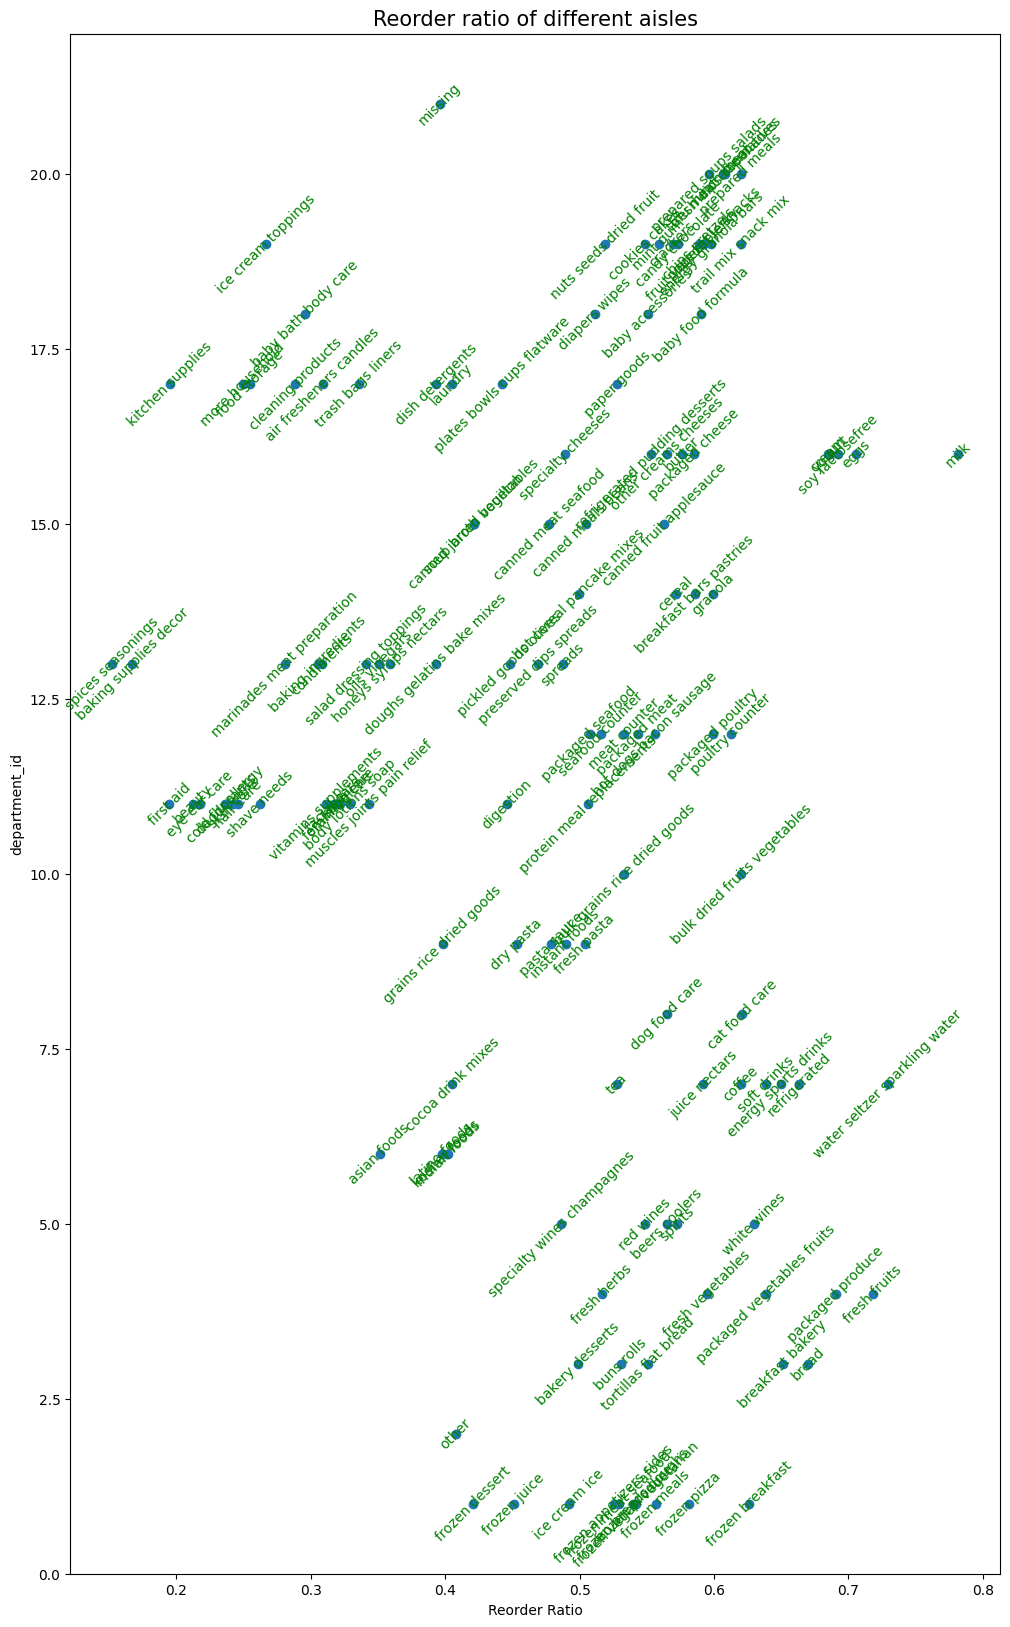

In [ ]:
grouped_df = order_products_prior_df.groupby(['department_id','aisle'])['reordered'].aggregate('mean').reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation = 45, ha = 'center', va = 'center', color = 'green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title('Reorder ratio of different aisles', fontsize = 15)
plt.show()

*  Add to Cart - 재주문 비율

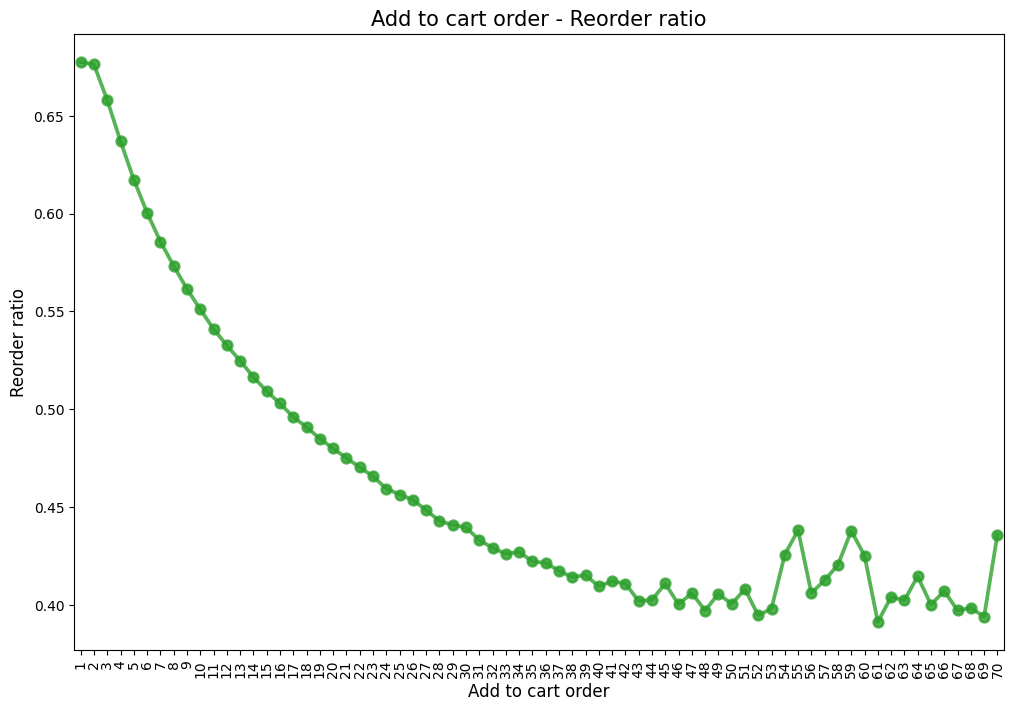

In [ ]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df['add_to_cart_order'].copy()
order_products_prior_df.loc[order_products_prior_df["add_to_cart_order_mod"]>70, "add_to_cart_order_mod"] = 70
grouped_df = order_products_prior_df.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x = grouped_df['add_to_cart_order_mod'].values, y = grouped_df['reordered'].values, alpha = 0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize = 12)
plt.xlabel('Add to cart order', fontsize = 12)
plt.title('Add to cart order - Reorder ratio', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

-> 우리가 빈번하게 사용되는 상품들은 첫 번째 상품인 경향이 있고 그 이후에 가능 한 새로운 상품을 찾음.

*  변수들을 반영한 시간에 의한 재주문

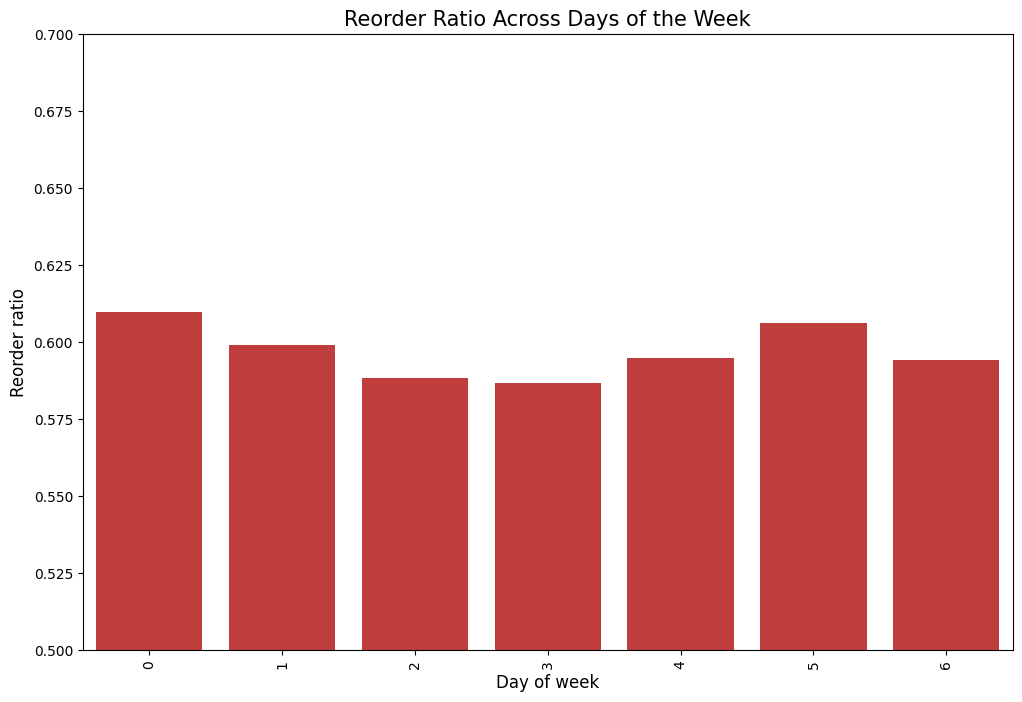

In [ ]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='order_dow', y='reordered', data=grouped_df, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder Ratio Across Days of the Week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

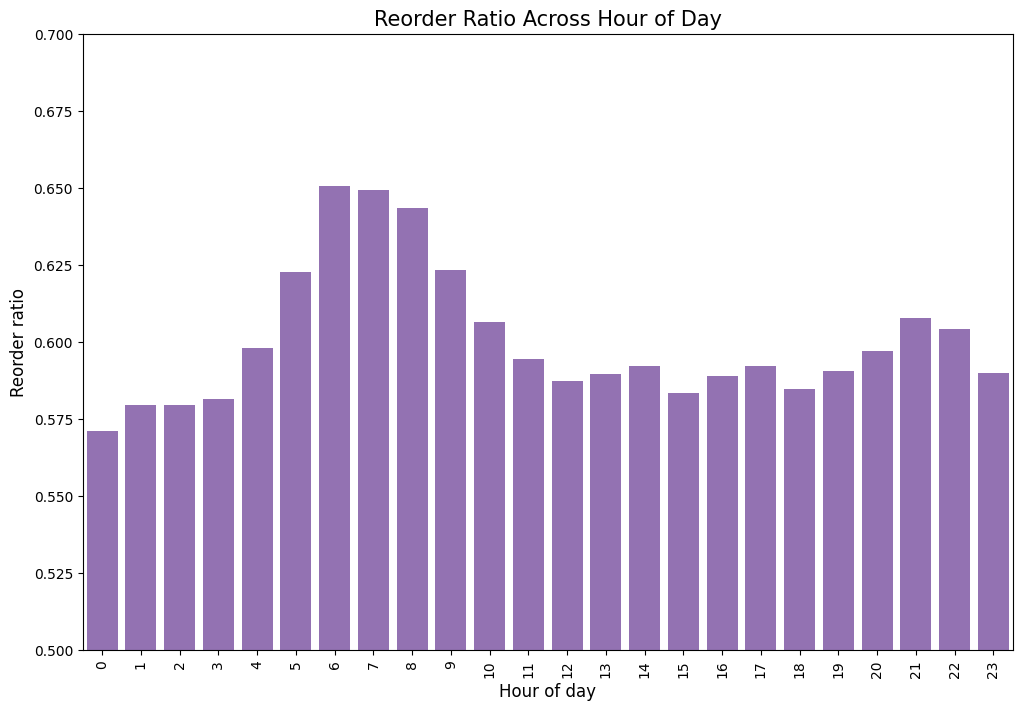

In [ ]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x='order_hour_of_day', y='reordered', data=grouped_df, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder Ratio Across Hour of Day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

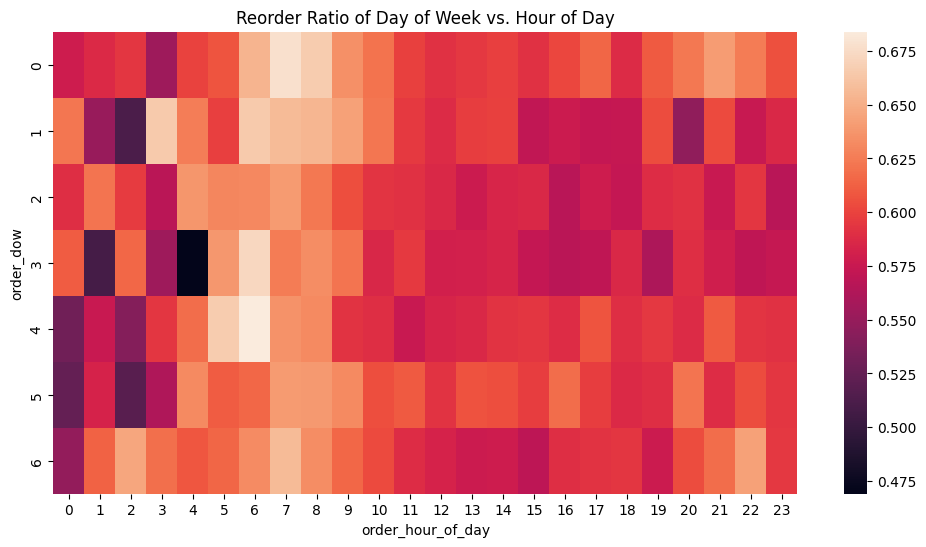

In [ ]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_df)
plt.title("Reorder Ratio of Day of Week vs. Hour of Day")
plt.show()

-> 재주문 비율은 하루의 늦은 시간과 비교했을 때 아침 일찍 주문하는 비율이 더 높다는 것을 알 수 있음.

## 새로운 전처리와 시각화

*  각 시간대별 가장 잘 팔리는 품목 확인



In [13]:
# 전처리 식 - 데이터셋 병합
orders_train = orders_df[orders_df['eval_set']=='train']
orders_train = pd.merge(orders_train, order_products_train_df, on='order_id',how = 'left')
orders_train_products = pd.merge(orders_train, products_df, on='product_id', how='left')
orders_train_products_department = pd.merge(orders_train_products, departments_df, on='department_id', how='left')
print('orders_train_products_department\n', orders_train_products_department.head(5))


orders_train_products_department
    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   1187899        1    train            11          4                  8   
1   1492625        2    train            15          1                 11   
2   1492625        2    train            15          1                 11   
3   1492625        2    train            15          1                 11   
4   1492625        2    train            15          1                 11   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                    14.0     27845.0                9.0        0.0   
1                    30.0     13640.0                7.0        0.0   
2                    30.0      9387.0               10.0        0.0   
3                    30.0     24838.0               12.0        0.0   
4                    30.0     38547.0               13.0        0.0   

                           product_name  aisle_id  department_id  department

In [24]:
# 전처리 식 - 데이터 셋 추출
hourly_top_products = orders_train_products_department.groupby(['order_hour_of_day', 'product_id', 'product_name']).size().reset_index(name='order_count')
top_selling_products_per_hour = hourly_top_products.loc[hourly_top_products.groupby('order_hour_of_day')['order_count'].idxmax()]
top_selling_products_per_hour = pd.DataFrame(top_selling_products_per_hour)
print(top_selling_products_per_hour[['order_hour_of_day', 'product_name', 'order_count']])

        order_hour_of_day            product_name  order_count
921                     0            Strawberries           18
3216                    1  Bag of Organic Bananas           13
4879                    2  Bag of Organic Bananas           10
5942                    3  Bag of Organic Bananas            6
7281                    4     Organic Blueberries            5
8641                    5             Large Lemon            8
9913                    6    Organic Strawberries           18
14600                   7                  Banana           62
21530                   8    Organic Strawberries          117
31706                   9    Organic Strawberries          147
43671                  10    Organic Strawberries          179
63900                  11             Large Lemon          212
77084                  12             Large Lemon          225
83244                  13    Organic Strawberries          199
96652                  14    Organic Strawberries      

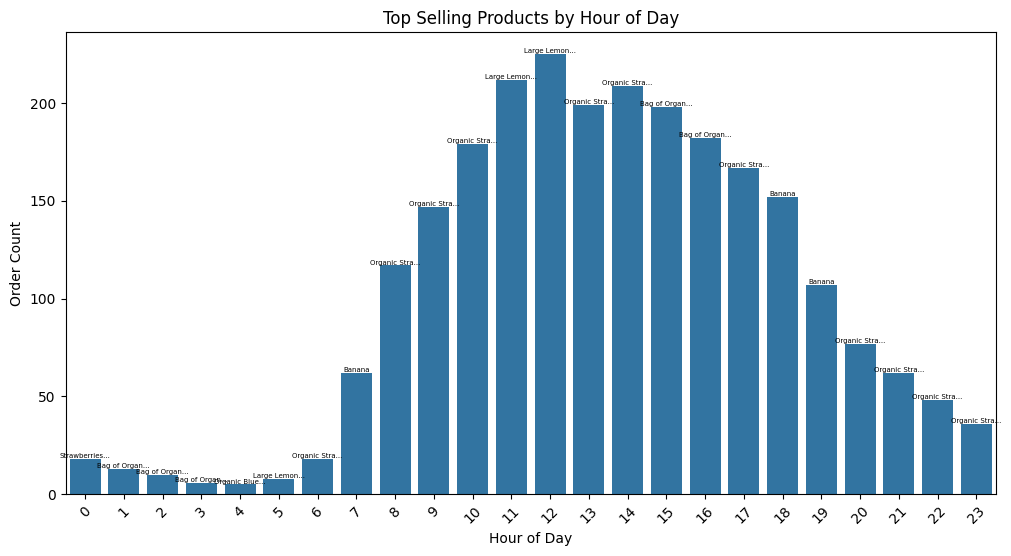

In [33]:
# 막대 그래프 생성
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='order_hour_of_day', y='order_count', data=top_selling_products_per_hour)
plt.xlabel('Hour of Day')
plt.ylabel('Order Count')
plt.title('Top Selling Products by Hour of Day')
plt.xticks(rotation=45)
for index, row in top_selling_products_per_hour.iterrows():
    product_name = row['product_name']
    if len(product_name) > 10:
        product_name = product_name[:12] + '...'
    barplot.text(row['order_hour_of_day'], row['order_count'] + 0.5, product_name,
                 color='black', ha="center", rotation=0, fontsize=5)
plt.show()
